In [1]:
# SEM Analysis

import pandas as pd, plspm.config as c
from plspm.plspm import Plspm
from plspm.scheme import Scheme
from plspm.mode import Mode

TAM = pd.read_csv('TAM.csv', index_col=0)

# Establish relationships between constructs
structure = c.Structure()
structure.add_path(["SN"], ["PU", "PEU", "BI", "ATT"])
structure.add_path(["OQ"], ["PU"])
structure.add_path(["CP"], ["PEU", "ATT", "BI"])
structure.add_path(["PEU"], ["PU", "ATT", "BI", "ASU"])
structure.add_path(["PU"], ["ATT", "BI"])
structure.add_path(["ATT"], ["BI"])
structure.add_path(["BI"], ["ASU"])

# Establish relationships between manifest and latent variables (the constructs)
config = c.Config(structure.path(), scaled=False)
config.add_lv_with_columns_named("OQ", Mode.A, TAM, "OQ")
config.add_lv_with_columns_named("SN", Mode.A, TAM, "SN")
config.add_lv_with_columns_named("PU", Mode.A, TAM, "PU")
config.add_lv_with_columns_named("ATT", Mode.A, TAM, "ATT")
config.add_lv_with_columns_named("BI", Mode.A, TAM, "BI")
config.add_lv_with_columns_named("ASU", Mode.A, TAM, "ASU")
config.add_lv_with_columns_named("CP", Mode.A, TAM, "CP")
config.add_lv_with_columns_named("PEU", Mode.A, TAM, "PEU")

# Check that the data are quantitative metric scale type
print(config.metric())

# Estimate the path model, using the Partial Least Squares (PLS) algorithm
plspm_calc = Plspm(TAM, config, Scheme.PATH, bootstrap=True, bootstrap_iterations=5000)

# Visualize results
print(plspm_calc.goodness_of_fit())
print(plspm_calc.unidimensionality())
print(plspm_calc.inner_summary())
print(plspm_calc.crossloadings())
print(plspm_calc.outer_model())
print(plspm_calc.inner_model())
print(plspm_calc.path_coefficients())
print(plspm_calc.effects())
print(plspm_calc.scores())


True


C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.__summaries = self.__summaries.append(_summary(dv, regression)).reset_index(drop=True)
C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.__summaries = self.__summaries.append(_summary(dv, regression)).reset_index(drop=True)
C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.__summaries = self.__summaries.append(_summary(dv, regression)).reset_index(drop=True)
C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is depre

C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights = weights.append(results["weights"])
C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:102: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_squared = r_squared.append(results["r_squared"])
C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:103: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_effects = total_effects.append(results["total_effects"])
C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  paths = paths.append(results["pat

0.6399540724868171
    mode  mvs  cronbach_alpha  dillon_goldstein_rho   eig_1st   eig_2nd
CP     A  4.0        0.887122              0.922405  2.994879  0.457844
OQ     A  2.0        0.846654              0.928787  1.734085  0.265915
SN     A  2.0        0.874773              0.941076  1.777420  0.222580
PEU    A  4.0        0.869575              0.911353  2.881687  0.542891
PU     A  4.0        0.934603              0.953453  3.347059  0.328812
ATT    A  4.0        0.939238              0.956470  3.384106  0.256604
BI     A  4.0        0.893605              0.926125  3.032536  0.387091
ASU    A  2.0        0.827871              0.920755  1.706296  0.293704
           type  r_squared  r_squared_adj  block_communality  mean_redundancy  \
ASU  Endogenous   0.454746       0.450766           0.851467         0.387201   
ATT  Endogenous   0.715354       0.711168           0.845567         0.604879   
BI   Endogenous   0.598041       0.590625           0.757738         0.453158   
CP    Exo

In [4]:
# Perform Common Method Bias (CMB) test

import numpy as np
import pandas as pd
from scipy.stats import f

df=plspm_calc.crossloadings()

# Calculate the correlation matrix between the observed variables using the crossloadings
corr_matrix = df.corr()

# Calculate the principal components of the correlation matrix
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)
first_component = eigenvectors[:, 0]

# Calculate the loading of each manifest variable in the first principal component
loadings = np.abs(df @ first_component)

# Calculate the proportion of total variance explained by the first principal component
total_variance = np.sum(eigenvalues)
explained_variance = eigenvalues[0]
explained_variance_ratio = explained_variance / total_variance

print(f"The first component explains {explained_variance_ratio * 100:.2f}% of the total variance")


The first component explains 33.89% of the total variance


In [2]:
# Elimination of unsupported hypotheses

import pandas as pd, plspm.config as c
from plspm.plspm import Plspm
from plspm.scheme import Scheme
from plspm.mode import Mode

TAM = pd.read_csv('TAM.csv', index_col=0)

# Establish relationships between constructs
structure = c.Structure()
structure.add_path(["SN"], ["PEU", "BI"])
structure.add_path(["OQ"], ["PU"])
structure.add_path(["CP"], ["PEU", "ATT", "BI"])
structure.add_path(["PEU"], ["PU", "ATT"])
structure.add_path(["PU"], ["ATT"])
structure.add_path(["ATT"], ["BI"])
structure.add_path(["BI"], ["ASU"])

# Establish relationships between manifest and latent variables (the constructs)
config = c.Config(structure.path(), scaled=False)
config.add_lv_with_columns_named("OQ", Mode.A, TAM, "OQ")
config.add_lv_with_columns_named("SN", Mode.A, TAM, "SN")
config.add_lv_with_columns_named("PU", Mode.A, TAM, "PU")
config.add_lv_with_columns_named("ATT", Mode.A, TAM, "ATT")
config.add_lv_with_columns_named("BI", Mode.A, TAM, "BI")
config.add_lv_with_columns_named("ASU", Mode.A, TAM, "ASU")
config.add_lv_with_columns_named("CP", Mode.A, TAM, "CP")
config.add_lv_with_columns_named("PEU", Mode.A, TAM, "PEU")

# Estimate the path model, using the Partial Least Squares (PLS) algorithm
plspm_calc = Plspm(TAM, config, Scheme.PATH, bootstrap=True, bootstrap_iterations=5000)

# Visualize results
print(plspm_calc.goodness_of_fit())
print(plspm_calc.unidimensionality())
print(plspm_calc.inner_summary())
print(plspm_calc.crossloadings())
print(plspm_calc.outer_model())
print(plspm_calc.inner_model())
print(plspm_calc.path_coefficients())
print(plspm_calc.effects())
print(plspm_calc.scores())


True


C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.__summaries = self.__summaries.append(_summary(dv, regression)).reset_index(drop=True)
C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.__summaries = self.__summaries.append(_summary(dv, regression)).reset_index(drop=True)
C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.__summaries = self.__summaries.append(_summary(dv, regression)).reset_index(drop=True)
C:\Users\sainz\anaconda3\lib\site-packages\plspm\inner_model.py:74: FutureWarning: The frame.append method is depre

C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights = weights.append(results["weights"])
C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:102: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_squared = r_squared.append(results["r_squared"])
C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:103: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_effects = total_effects.append(results["total_effects"])
C:\Users\sainz\anaconda3\lib\site-packages\plspm\bootstrap.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  paths = paths.append(results["pat

0.6387052386429888
    mode  mvs  cronbach_alpha  dillon_goldstein_rho   eig_1st   eig_2nd
CP     A  4.0        0.887122              0.922405  2.994879  0.457844
OQ     A  2.0        0.846654              0.928787  1.734085  0.265915
SN     A  2.0        0.874773              0.941076  1.777420  0.222580
PEU    A  4.0        0.869575              0.911353  2.881687  0.542891
PU     A  4.0        0.934603              0.953453  3.347059  0.328812
ATT    A  4.0        0.939238              0.956470  3.384106  0.256604
BI     A  4.0        0.893605              0.926125  3.032536  0.387091
ASU    A  2.0        0.827871              0.920755  1.706296  0.293704
           type  r_squared  r_squared_adj  block_communality  mean_redundancy  \
ASU  Endogenous   0.452944       0.450954           0.851412         0.385642   
ATT  Endogenous   0.714050       0.710908           0.845563         0.603774   
BI   Endogenous   0.591871       0.587386           0.757748         0.448489   
CP    Exo

In [3]:
# Create the dataset with the values of the constructs for each record (each surveyed person)
plspm_calc.scores().to_csv('TAM_constructs.csv', index=False)

In [5]:
# Normalize the data in the range [0, 1]

import pandas as pd

# Read CSV file with original data
df = pd.read_csv('TAM_constructs.csv')

# Normalize the data in each column
for col in df.columns:
    X_min = df[col].min()
    X_max = df[col].max()
    df[col] = (df[col] - X_min) / (X_max - X_min)

# Write CSV file with normalized data
df.to_csv('TAM_normalized_constructs.csv', index=False)


Fold 1
8/8 [==============================] - 0s 713us/step
RMSE train: 0.10184
R2 train: 0.57626
RMSE test: 0.09537
R2 test: 0.59192

Importancia relativa de cada predictor de entrada:
 [0.60674334 0.47581255 0.8317336 ]


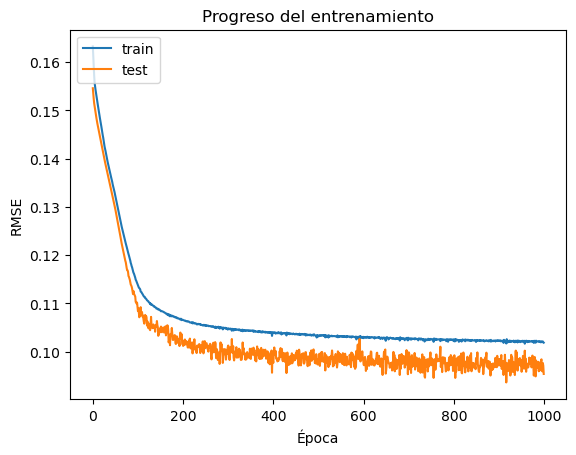

Fold 2
8/8 [==============================] - 0s 855us/step
RMSE train: 0.09927
R2 train: 0.58369
RMSE test: 0.12934
R2 test: 0.39547

Importancia relativa de cada predictor de entrada:
 [0.766209   0.66959727 0.8314194 ]


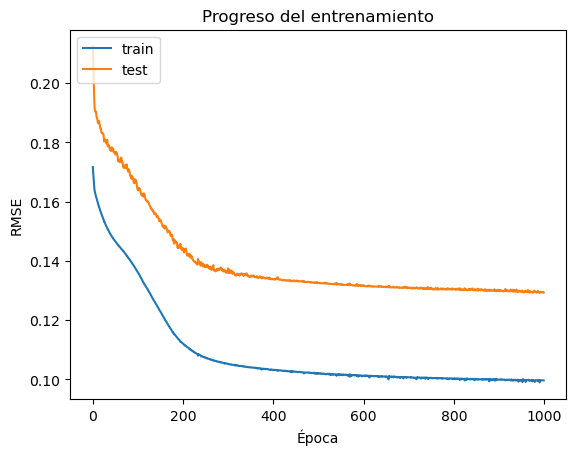

Fold 3
8/8 [==============================] - 0s 712us/step
RMSE train: 0.10015
R2 train: 0.60081
RMSE test: 0.11172
R2 test: 0.21338

Importancia relativa de cada predictor de entrada:
 [0.7579529  0.45299044 0.77974904]


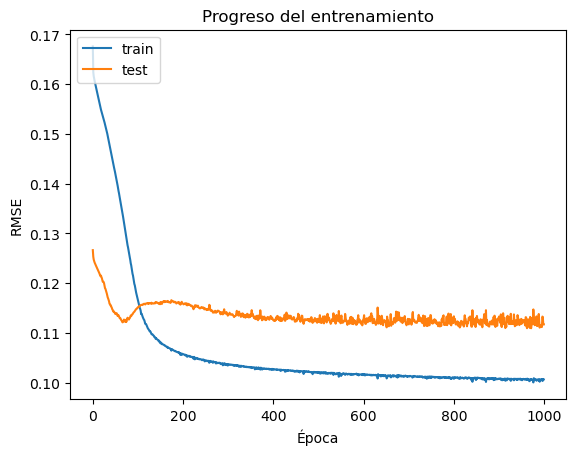

Fold 4
8/8 [==============================] - 0s 852us/step
RMSE train: 0.10374
R2 train: 0.55228
RMSE test: 0.08905
R2 test: 0.75649

Importancia relativa de cada predictor de entrada:
 [0.66949636 0.49529487 0.9225927 ]


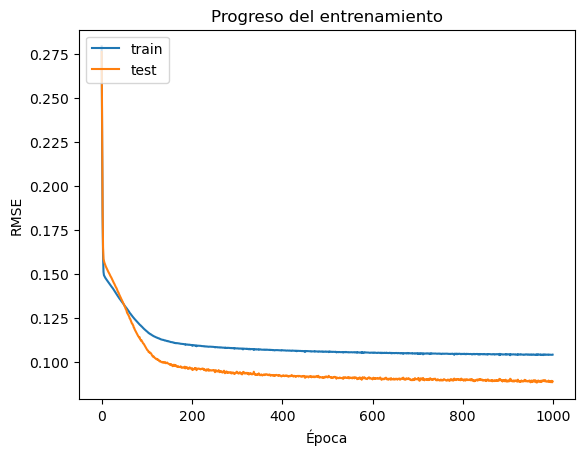

Fold 5
8/8 [==============================] - 0s 855us/step
RMSE train: 0.10242
R2 train: 0.55779
RMSE test: 0.10140
R2 test: 0.64935

Importancia relativa de cada predictor de entrada:
 [0.7354769  0.60582983 0.8609641 ]


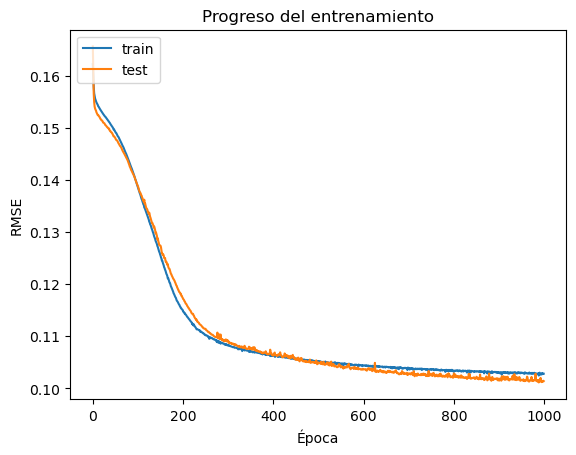

Fold 6
8/8 [==============================] - 0s 853us/step
RMSE train: 0.09851
R2 train: 0.60679
RMSE test: 0.12823
R2 test: 0.34908

Importancia relativa de cada predictor de entrada:
 [0.6320309  0.46582443 0.9215491 ]


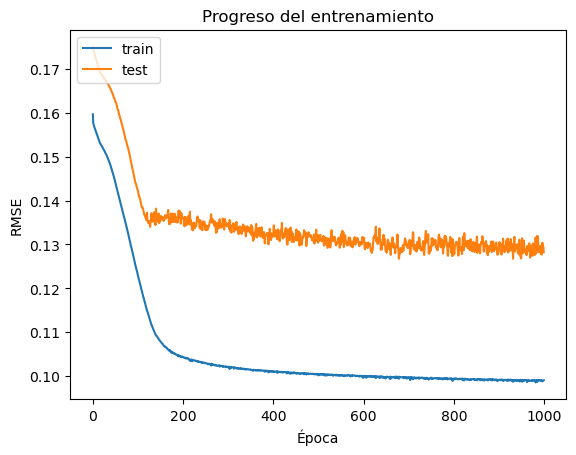

Fold 7
8/8 [==============================] - 0s 1ms/step
RMSE train: 0.09915
R2 train: 0.56589
RMSE test: 0.12234
R2 test: 0.59412

Importancia relativa de cada predictor de entrada:
 [0.65731275 0.5829177  0.762864  ]


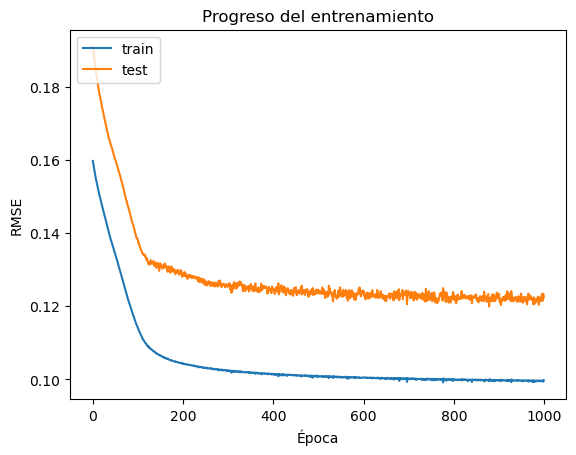

Fold 8
8/8 [==============================] - 0s 712us/step
RMSE train: 0.10407
R2 train: 0.57305
RMSE test: 0.08509
R2 test: 0.56308

Importancia relativa de cada predictor de entrada:
 [0.6046859 0.5861723 0.866084 ]


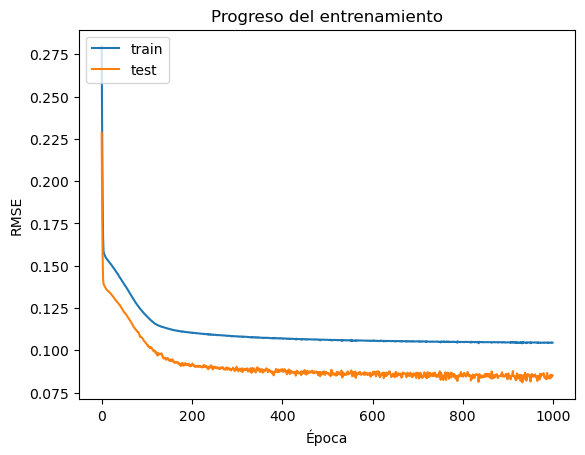

Fold 9
8/8 [==============================] - 0s 855us/step
RMSE train: 0.10157
R2 train: 0.55701
RMSE test: 0.09832
R2 test: 0.67584

Importancia relativa de cada predictor de entrada:
 [0.7295736 0.5887426 0.7475759]


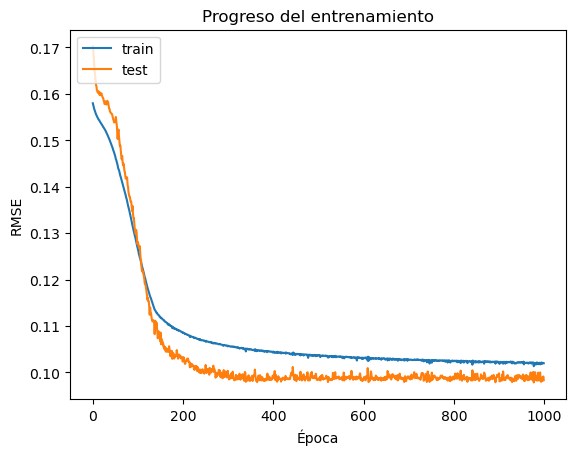

Fold 10
8/8 [==============================] - 0s 778us/step
RMSE train: 0.10397
R2 train: 0.56780
RMSE test: 0.07712
R2 test: 0.61604

Importancia relativa de cada predictor de entrada:
 [0.7140306 0.5511419 0.7012905]


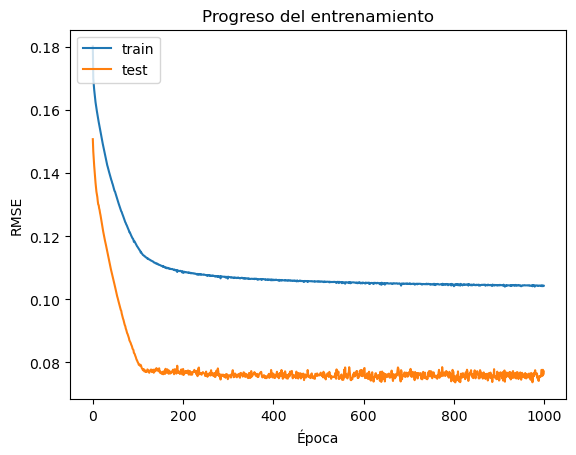

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 2)                 8         
                                                                 
 dense_35 (Dense)            (None, 1)                 3         
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
RMSE train promedio: 0.10147 +/- 0.00200
RMSE test promedio: 0.10380 +/- 0.01744
R2 train promedio: 0.57414
R2 test promedio: 0.54048

Resultados de cada fold:
    RMSE test   R2 test  RMSE train  R2 train
0   0.095368  0.591920    0.101842  0.576264
1   0.129339  0.395472    0.099269  0.583689
2   0.111723  0.213379    0.100146  0.600813
3   0.089050  0.756491    0.103743  0.552283
4   0.101404  0.649349  

In [8]:
# ANN Analysis: BI construct prediction and sensitivity analysis

import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# Define custom RMSE loss function
def rmse_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    return rmse

# Load data from CSV file: columns of constructs not related to BI have been removed
data = pd.read_csv('TAM_normalized_constructs_BI_prediction.csv')

# Split data into inputs (X) and output (y)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1:].values

# Define the number of folds for cross validation and the lists for storing the results of each fold
n_folds = 10
rmse_test_list = []
rmse_train_list = []
r2_test_list = []
r2_train_list=[]
importance_list = []

# Create KFold instance
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Iterate on each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    
    print(f"Fold {fold + 1}")
    
    # Splitting data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create the neural network
    model = Sequential()
    model.add(Dense(2, input_dim=3, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss=rmse_loss, optimizer=optimizers.RMSprop(learning_rate=0.001))

    # Training of the model
    history = model.fit(X_train, y_train, epochs=1000, batch_size=2, verbose=0, validation_data=(X_test, y_test))

    # Obtain model predictions
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Evaluate the model in the train set
    rmse_train = model.evaluate(X_train, y_train, verbose=0)
    rmse_train_list.append(rmse_train)
    print(f"RMSE train: {rmse_train:.5f}")
    r2_train = r2_score(y_train, y_pred_train)
    r2_train_list.append(r2_train)
    print(f"R2 train: {r2_train:.5f}")
    
    # Evaluate the model in the test set
    rmse_test = model.evaluate(X_test, y_test, verbose=0)
    rmse_test_list.append(rmse_test)
    print(f"RMSE test: {rmse_test:.5f}")
    r2_test = r2_score(y_test, y_pred)
    r2_test_list.append(r2_test)
    print(f"R2 test: {r2_test:.5f}")

    # Calculate the relative importance of each input predictor
    layer = model.layers[0]
    weights = layer.get_weights()
    importance = np.abs(weights[0])
    importance_avg = np.mean(importance, axis=1)
    importance_list.append(importance_avg)
    print()
    print("Importancia relativa de cada predictor de entrada:\n", importance_avg)
        
    # Visualize the training
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Progreso del entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('RMSE')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Visualize the neural network
plot_model(model, to_file='TAM_model.png', show_shapes=True, show_layer_names=True)
print(model.summary())
    
# Calculate mean RMSE and standard deviation
rmse_train_mean = np.mean(rmse_train_list)
rmse_train_std = np.std(rmse_train_list)
print(f"RMSE train promedio: {rmse_train_mean:.5f} +/- {rmse_train_std:.5f}")
rmse_test_mean = np.mean(rmse_test_list)
rmse_test_std = np.std(rmse_test_list)
print(f"RMSE test promedio: {rmse_test_mean:.5f} +/- {rmse_test_std:.5f}")

# Calculate mean R2
r2_train_mean = np.mean(r2_train_list)
print(f"R2 train promedio: {r2_train_mean:.5f}")
r2_test_mean = np.mean(r2_test_list)
print(f"R2 test promedio: {r2_test_mean:.5f}")

# Display summary table and export it to csv
print()
results_df = pd.DataFrame({"RMSE test": rmse_test_list, "R2 test": r2_test_list,"RMSE train": rmse_train_list, "R2 train": r2_train_list})
print("Resultados de cada fold:\n", results_df)
results_df.to_csv("Results_TAM.csv", index=True)
print()

# Calculate the mean relative importance of each input predictor
print()
importance_df = pd.DataFrame(importance_list, columns=data.columns[:-1])
importance_mean = importance_df.mean()

# Display summary table of relative importance and export it to csv
print("Importancia relativa de cada predictor de entrada para cada fold:\n", importance_df)
print()
print("Importancia relativa promedio de cada predictor de entrada:")
print(importance_mean)
importance_df.to_csv("Sensitivity_analysis_TAM.csv", index=True)
